In [5]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import umap.umap_ as umap
import seaborn as sns
stat_path = r'NZ_statistics.csv'
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.decomposition import PCA

In [2]:
#Reading data
stat_path_full = os.path.join(stat_path)
df = pd.read_csv(stat_path_full,index_col=0)
#Drop columns
df = df.drop(['Num_of_loc','Num_of_days'],axis=1)
#Transform RoG
df['RoG k2'] = df['RoG k2']/df['RoG']
df['RoG k4'] = df['RoG k4']/df['RoG']
df['RoG k8'] = df['RoG k8']/df['RoG']
#Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [3]:
#Get potential combinations 
import itertools

combinations = []
for r in range(1, 3):  # For combinations of 1, 2, and 3 elements
    combinations.extend(itertools.combinations(df.columns, r))
#Recreate DF
df_scaled = pd.DataFrame(df_scaled,columns=df.columns,index=df.index)


In [ ]:
# Run tests
combs = {}
for w in combinations:
    scores_ch = {}
    scores_db = {}
    scores_s = {}
    df_filter = df_scaled.drop([*w],axis=1)
    
    #Broken-stick criterion
    pca = PCA(n_components=5,random_state=42)
    principal_components = pca.fit_transform(df_filter)
    thersholds = [1/(11-x) for x in range(1,6)]
    stacked = np.vstack([pca.explained_variance_ratio_,thersholds])
    n_components = (stacked[0,:]>stacked[1,:]).sum()
    #Proper PCA
    pca = PCA(n_components=n_components,random_state=42)
    principal_components = pca.fit_transform(df_filter)
    print(np.sum(pca.explained_variance_ratio_))
    Z = linkage(df_scaled, method='ward')
    # Elbow Method on Dendrogram
    last = Z[-20:, 2]
    last_rev = last[::-1]
    idxs = np.arange(1, len(last) + 1)
    plt.plot(idxs, last_rev)

    acceleration = np.diff(last, 2)  # 2nd derivative of the distances
    acceleration_rev = acceleration[::-1]
    plt.plot(idxs[:-2] + 1, acceleration_rev)

    k_elbow = acceleration_rev.argmax() + 2  # Add 2 to get the right number of clusters
    print(f"Optimal number of clusters based on the elbow method: {k_elbow}")
    
    for n in range(2,6):
        agglomerative_clustering = AgglomerativeClustering(n_clusters=n, metric='euclidean', linkage='ward')
        clusters = agglomerative_clustering.fit_predict(df_filter)

        # Add cluster labels to the original data
        score = davies_bouldin_score(df_filter, clusters)
        score2 = calinski_harabasz_score(df_filter,clusters)
        score3 = silhouette_score(df_filter,clusters)
        scores_ch[n] = score2
        scores_db[n] = score
        scores_s[n] = score3
    print("Drop:",w)
    print(max(scores_ch,key=scores_ch.get),max(scores_ch.values()))
    print(min(scores_db,key=scores_db.get),min(scores_db.values()))
    print(max(scores_s,key=scores_s.get),max(scores_s.values()))
    combs[w] = (max(scores_ch,key=scores_ch.get),max(scores_ch.values()),
               min(scores_db,key=scores_db.get),min(scores_db.values()),
               max(scores_s,key=scores_s.get),max(scores_s.values()),
              (k_elbow))

In [ ]:
cluster_df = pd.DataFrame(combs).T
cluster_df.columns = ['CCH','CH','CDB','DB','CS','S','EL']
cluster_df

In [6]:
#Selected parameters - process
#Reading data
stat_path_full = os.path.join(stat_path)
df = pd.read_csv(stat_path_full,index_col=0)
#Drop columns
df = df.drop(['Num_of_loc','Num_of_days','Median from Home'],axis=1)
#Transform RoG
df['RoG k2'] = df['RoG k2']/df['RoG']
df['RoG k4'] = df['RoG k4']/df['RoG']
df['RoG k8'] = df['RoG k8']/df['RoG']
#Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
#PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_scaled)

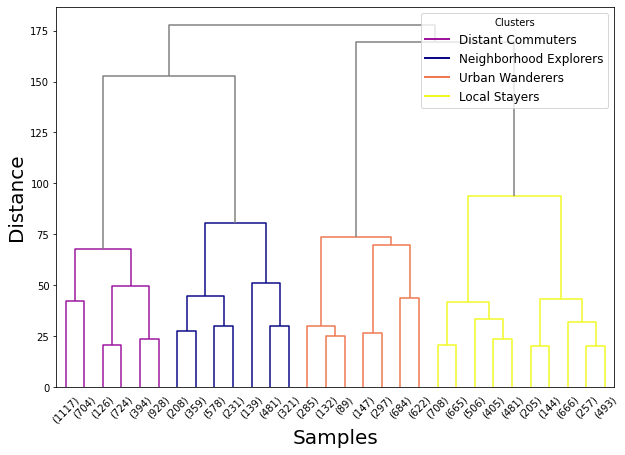

In [7]:
#Dendrogram PLOT
import matplotlib.pyplot as plt
from cycler import cycler

cluster_colors = {
    2: '#f0f922',    # Local Stayers
    3: '#ee7850',   # Urban Wanderers
    0: '#9c179d',  # Distant Commuters
    1: '#0c0987', # Neighborhood Explorers
}

# Set a custom color cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=['grey']+['#9c179d','#0c0987','#ee7850','#f0f922'])

# Compute the linkage matrix
Z = linkage(principal_components, method='ward')

custom_palette = ['#9c179d','#0c0987','#ee7850','#f0f922']
cluster_labels = ['Distant Commuters','Neighborhood Explorers','Urban Wanderers','Local Stayers']
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z,truncate_mode='lastp')
plt.xlabel('Samples',size=20)
plt.ylabel("Distance",size=20)
# plt.show()

# Add legend manually
legend_patches = [
    plt.Line2D([0], [0], color=color, lw=2, label=label)
    for color, label in zip(custom_palette, cluster_labels)
]

plt.legend(handles=legend_patches, title="Clusters", loc='upper right', fontsize=12)

plt.savefig('NZ_dendro.png',dpi=300, facecolor='white')

In [9]:
# Fit Agglomerative Clustering
num_clusters = 4  # Adjust based on dendrogram analysis
agglomerative_clustering = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
clusters = agglomerative_clustering.fit_predict(principal_components)

# Add cluster labels to the original| data
df['Cluster'] = clusters

In [10]:
#Rebuild full data
stat_path_full = os.path.join(stat_path)
df = pd.read_csv(stat_path_full,index_col=0)
df['RoG k2'] = df['RoG k2']/df['RoG']
df['RoG k4'] = df['RoG k4']/df['RoG']
df['RoG k8'] = df['RoG k8']/df['RoG']
df['Cluster'] = clusters


In [11]:
#Average parameters
df[[x for x in df.columns if 'Return' not in x and 'Median' not in x ]].groupby('Cluster').agg(['mean','std'])


C:\Users\kamil\AppData\Local\Temp\ipykernel_12216\260447847.py:2: FutureWarning: ['Num_of_days'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df[[x for x in df.columns if 'Return' not in x and 'Median' not in x ]].groupby('Cluster').agg(['mean','std'])


Real Entropy                    RoG              Jump (median)  \
                mean       std         mean          std          mean   
Cluster                                                                  
0           2.405817  0.385437  1187.592669   859.687864   5096.731945   
1           1.887383  0.473534  4150.303613  2038.349595  15624.173431   
2           2.264130  0.572950   490.461420   433.536359   3609.946121   
3           1.524352  0.388259  1290.530197   956.442114   6643.062787   

                     Num_of_loc           Frequency (top1)            \
                 std       mean       std             mean       std   
Cluster                                                                
0        3451.497240  17.134879  6.505540         0.753057  0.126707   
1        8908.870613  12.485542  4.937466         0.637192  0.133775   
2        3248.049951  14.400709  8.785893         0.824092  0.130842   
3        5133.997579   6.907338  2.911595         0.799995  0.125617   

        Random Entropy              RoG k2              RoG k4            \
                  mean       std      mean       std      mean       std   
Cluster                                                                    
0             4.010983  0.494325  1.080381  0.270987  1.155471  0.091177   
1             3.509112  0.666469  1.111189  0.229633  1.109576  0.066353   
2             3.601191  0.857205  0.428206  0.271747  0.866335  0.220293   
3             2.630400  0.722388  1.080808  0.139726  1.050654  0.046539   

           RoG k8            
             mean       std  
Cluster                      
0        1.088169  0.057105  
1        1.046823  0.039287  
2        1.010743  0.090022  
3        1.006851  0.012812

In [12]:
#Population
df.groupby('Cluster').count().iloc[:,0]

Cluster
0    4530
1    2317
2    2256
3    3993
Name: Real Entropy, dtype: int64

In [13]:
#Population ratio
df.groupby('Cluster').count().iloc[:,0]/df.groupby('Cluster').count().iloc[:,0].sum()

Cluster
0    0.345907
1    0.176924
2    0.172266
3    0.304902
Name: Real Entropy, dtype: float64

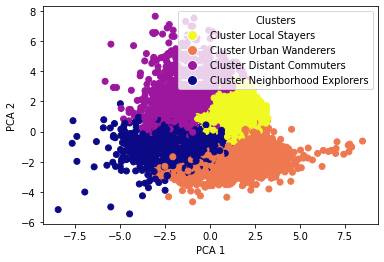

In [15]:
unique_clusters = np.unique(df['Cluster'])

# Define custom colors for each cluster
cluster_colors = {
    3: '#f0f922',    # Cluster 0 color
    2: '#ee7850',   # Cluster 1 color
    1: '#9c179d',  # Cluster 2 color
    0: '#0c0987', # Cluster 3 color
}
names = ['Local Stayers','Urban Wanderers','Distant Commuters','Neighborhood Explorers']

point_colors = df['Cluster'].map(cluster_colors)

scatter = plt.scatter(principal_components[:,0],principal_components[:,1], c=point_colors)
plt.xlabel('PCA 1')
plt.ylabel("PCA 2")

# Create a legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {cluster}')
    for color, cluster in zip(cluster_colors.values(),names)
]
plt.legend(handles=legend_handles, title="Clusters", frameon=True, loc='upper right')

plt.savefig("PCA_NZ.png",dpi=300, facecolor='white')